# Requirement 1
## *Single product and stochastic environment*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

### Environment
A stochastic environment, where we have a distribution over the valuations of a single type of product

In [2]:
class SingleProductStochasticEnvironment:
  def __init__(self, T, valuation_distr=stats.uniform):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = valuation_distr.rvs(size=T)

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

### Agent - *UCB1 algorithm* **ignoring the inventory constraint**

In [3]:
class UCB1:
    def __init__(self, T, P, range=1):
        self.range = range # Range of the reward
        self.P = P # Prices' set cardinality
        self.T = T # Number of rounds
        self.pi_t = None # Init price

        self.average_rewards = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)

        self.t = 0 # Starting round

    def pull_arm(self):
        # Check if the round is less then number of prices
        if self.t < self.P:
            # then set it as product_price
            self.pi_t = self.t
        else:
            # Compute UCB1
            ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls)

            # Extract the price that maximizes the UCB1
            self.pi_t = np.argmax(ucbs)

        return self.pi_t

    def update(self, reward):
        self.N_pulls[self.pi_t] += 1

        # As average, we have (total purchasing) / (number of times of purchasing)
        self.average_rewards[self.pi_t] += (reward - self.average_rewards[self.pi_t])/self.N_pulls[self.pi_t]
        self.t += 1

### Clairvoyant - **ignoring invetory constraint**

In [4]:
class SingleProductStochasticClairvoyant:
    def __init__(self, T, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(
            c,
            A_eq=A_eq,
            b_eq=b_eq,
            bounds=(0, 1)
        )
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

### Execution

In [5]:
# Parameters
T = 10000 # Time horizon

# Prices
price_step = T ** (-1/3) # From theory
prices = np.arange(0, 1, price_step)
P = len(prices)

# Valuation distribution
valuation_distr = stats.norm(loc=0.5, scale=1)

In [6]:
# Run clairvoyant
clairvoyant = SingleProductStochasticClairvoyant(T, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()
expected_clairvoyant_utilities

array([0.31025298, 0.31025298, 0.31025298, ..., 0.31025298, 0.31025298,
       0.31025298])

In [7]:
n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductStochasticEnvironment(T, valuation_distr)
  ucb_like_agent = UCB1(T, P, range=1)

  agent_rewards = []

  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

### Results

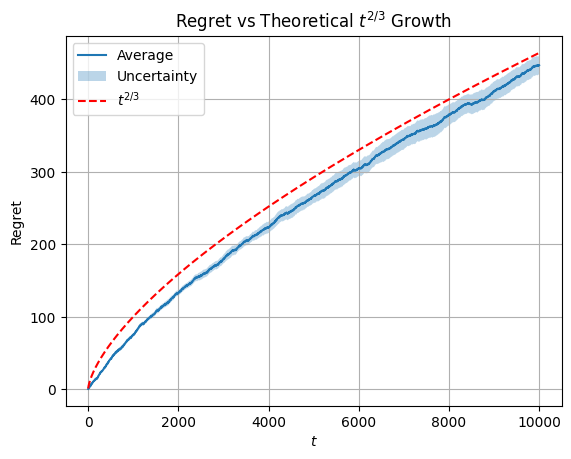

In [8]:
average_regret = regret_per_trial.mean(axis=0)  # mean
regret_sd = regret_per_trial.std(axis=0)        # standard deviation

t = np.arange(1, T+1)  # start from one to avoid t^{2/3} = 0^{2/3} = 0
regret_theory = t**(2/3)

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$t^{2/3}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.title("Regret vs Theoretical $t^{2/3}$ Growth")
plt.grid(True)
plt.show()

### Agent - *UCB1 algorithm* **with the inventory constraint**

In [9]:
class UCBLike():
    def __init__(self, T, B, P, range=1):
        self.T = T
        self.P = P
        self.range = range

        self.pi_t = None
        self.avg_f = np.zeros(self.P)
        self.avg_c = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)
        self.budget = B

        self.t = 0

    def compute_opt(self, f_ucbs, c_lcbs):
        # Per-round budget
        rho = (self.budget / (self.T - self.t + 1)) + 1.5

        ## Linear programming
        c = -f_ucbs

        # Constraint
        A_ub = [c_lcbs]
        b_ub = [rho]

        A_eq = [np.ones(self.P)]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(
            c,
            A_ub=A_ub,
            b_ub=b_ub,
            A_eq=A_eq,
            b_eq=b_eq,
            bounds=(0,1)
        )

        # Check if a solution is found
        if res.success:
            # in case, return it
            gamma = res.x
        else:
            # otherwise, set 1 to UCB-maximizing price
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1

        return gamma

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            return None

        if self.t < self.P:
            self.pi_t = self.t
        else:
            # Upper Confidence Bound
            f_ucbs = self.avg_f + self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Lower Confidence Bound
            c_lcbs = self.avg_c - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Price optimal distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)

            # Set current price
            self.pi_t = np.random.choice(self.P, p=gamma_t)

        return self.pi_t

    def update(self, f_t, c_t):
        # Update the number of pulled price
        self.N_pulls[self.pi_t] += 1

        # Update averages
        self.avg_f[self.pi_t] = self.avg_f[self.pi_t] + (f_t - self.avg_f[self.pi_t])/self.N_pulls[self.pi_t]
        self.avg_c[self.pi_t] = self.avg_c[self.pi_t] + (c_t - self.avg_c[self.pi_t])/self.N_pulls[self.pi_t]

        # Update budget
        self.budget = self.budget - c_t

        self.t += 1

### Clairvoyant - **with inventory constraint**

In [10]:
class SingleProductStochasticInventoryClaivoyant:
    def __init__(self, T, B, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices
        self.budget = B

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        # Per-round budget
        rho = (self.budget / self.T) + 1

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob]
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(
            c,
            A_eq=A_eq,
            b_eq=b_eq,
            A_ub=A_ub,
            b_ub=b_ub,
            bounds=(0, 1)
        )
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

### Execution

In [17]:
# Parameters
T = 10000
B = T * 45/100

# Prices
price_step = 0.2
prices = np.arange(0, 1, price_step)
P = len(prices)

# Valuation distribution
valuation_distr = stats.beta(a=1, b=1)

In [18]:
# Run clairvoyant
clairvoyant = SingleProductStochasticInventoryClaivoyant(T, B, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()
expected_clairvoyant_utilities

array([0.24, 0.24, 0.24, ..., 0.24, 0.24, 0.24])

In [19]:
n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductStochasticEnvironment(T)
  ucb_like_agent = UCBLike(T, B, P, range=1)

  agent_rewards = []
  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Check if budget is depleted -> reward always 0
    if pi_t == None:
      r_t = 0.
    else:
      # Get the actual price
      p_t = prices[pi_t]

      # Get reward
      r_t = env.round(p_t)

      # Update agent state
      ucb_like_agent.update(r_t, r_t > 0)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

### Results

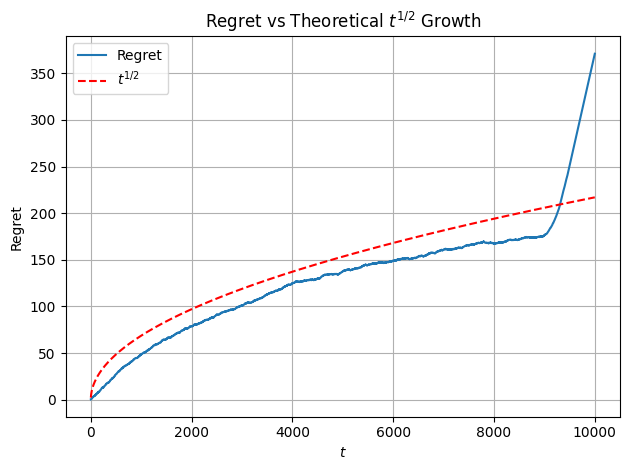

In [20]:
plt.plot(np.arange(T), average_regret, label=f'Regret')

t = np.arange(1, T + 1)  # start from 1 to avoid log(0)
theoretical_curve = t**(1/2) * (200/8500**(1/2))
plt.plot(t - 1, theoretical_curve, label="${t}^{1/2}$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical ${t}^{1/2}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()